# Detecting Machine Learning Model Data Drift using Azure ML & Azure Data Bricks 

## Session Objective

_"Change is the only constant in life”_ adage holds true for machine learning (ML) models in production, as over time they could deteriorate in their accuracy or in their predictive power as the distribution of input features change overtime typically, called data drift. This is more pronounced during times of extreme environment like COVID.

The goal of this tutorial is to provide an overview of the data drift concept as well as a walk-through of detecting data drift for in-production ML models in a scalable & efficient way using **Azure Databricks & Azure ML** . 


## Description

Data drift is one of the top reasons model accuracy degrades over time. For machine learning models, data drift is the change in model input data that leads to model performance degradation. Monitoring data drift helps detect these model performance issues apriori. Causes of data drift include:
1. **Upstream process changes like metric definition changes**
2. **Data quality issues, such as a broken CRM system which shows Revenue as null**
3. **Natural drift in the data, such as Revenue changing across quarters or due to external environment like COVID**

Our goal in this tutorial is to convey a theoretical and practical aspect of data drift used for in-production models in a scalable & efficient manner. The learnings can be applied for any machine learning model in any business.
 
We will talk about the power of Azure Machine Learning which simplifies data drift detection by computing a single metric abstracting the complexity of datasets being compared. These datasets may have hundreds of features and tens of thousands of rows. Once drift is detected, you can drill down into which features are causing the drift. You then inspect feature level metrics to debug and isolate the root cause for the drift. This top down approach makes it easy to monitor data instead of traditional rules-based techniques. All this can be done for multiple models in an automated way leveraging the power of Azure Data Bricks and Azure ML. 

The fundamental idea this tutorial will aim to convey is that incorporating Data drift for machine learning model would help in detecting model performance degradation apriori and reduce the cost of prediction gone wrong in a scalable and automated way.


## Prerequisites

*  Azure subscription. If you don't have an Azure subscription, create a [free](https://azure.microsoft.com/en-us/free/) account before you begin. 

*  [Azure Machine Learning workspace](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace). Try the [free or paid](https://azure.microsoft.com/en-us/free/services/machine-learning/) version of Azure Machine Learning today.

*  [Azure Machine Learning SDK](https://docs.microsoft.com/en-us/python/api/overview/azure/ml/?view=azure-ml-py) for Python installed, which includes the azureml-datasets package.

*  Azure Data Bricks with runtime 6.0 and above and Azure Data Lake storage(ADLS) mounted in it.

*  Training Data and Scoring Data in Parquet format




### Step 1 Save Training Data in parquet format

* Save training data in Azure Data lake storage(ADLS) in parquet format. Training data should contain final list of features which are used for training. Include timestamp for training. (Timestamp is optional for training data)

* Parquet format stores the metadata information in file and thus prevent data-type mismatch issues

* We had provided a sample python code below to maintain the consistency across different models

#### Python Code

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import pyarrow

def training_file_parquet(dataframe,save_path,columns_excluded=None):
  ####dataframe = Training Python data frame 
  ####save_path = save directory path for saving the file. Eg-'/dbfs/mnt/data/ModelOutput/Data_Drift/test_model/Training/'
  ####columns_excluded = column to exclude from data drift(List) - This is optional. It is used to exlude ID columns like customer ID etc which are not needed for data drift.
    if columns_excluded is not None:
        dataframe_v1 = dataframe.drop(columns_excluded, axis=1).copy(deep=True)
    else:
        dataframe_v1=dataframe.copy(deep=True)
    dataframe_v1['training_date'] = date.today()
    dataframe_v1['training_date'] = pd.to_datetime(dataframe_v1['training_date'], infer_datetime_format=True)
    model_save_path = save_path +  'training_data'+'.gzip'
    dataframe_v1.to_parquet(model_save_path,compression='gzip',engine='pyarrow')
    return

### Step 2 Save Scoring Data in Parquet Format
* Save Scoring data in Azure Data lake storage(ADLS) in parquet format.Scoring Data should contains final list of features which are used for scoring. 
* Add TimeStamp column while saving data into ADLS(Timestamp is mandatory)
* We had provided a sample python function below to maintain the consistency across different models

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import pyarrow
import os

  
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def scoring_file_parquet(dataframe,save_path,columns_excluded=None):
  ####dataframe = Scoring Python data frame
  ####save_path = Save directory path for saving the file. Eg-'/dbfs/mnt/data/ModelOutput/Data_Drift/test_model/Scoring/'
  ####columns_excluded = column to exclude from data drift(List) - This is optional. It is used to exlude ID columns like customer ID etc which are not needed for data drift.
    if columns_excluded is not None:
        dataframe_v1 = dataframe.drop(columns_excluded, axis=1).copy(deep=True)
    else:
        dataframe_v1=dataframe.copy(deep=True)
    dataframe_v1['scoring_date'] = date.today()
    dataframe_v1['scoring_date'] = pd.to_datetime(dataframe_v1['scoring_date'], infer_datetime_format=True)
    createFolder(save_path + datetime.today().strftime('%Y-%m-%d'))
    model_save_path = save_path + datetime.today().strftime('%Y-%m-%d') +'/'+ 'scoring_data_'+ str(date.today()) +'.gzip'
    dataframe_v1.to_parquet(model_save_path,compression='gzip',engine='pyarrow')
    return

### Step 3a-Create a Data drift monitor for each individual model
### Step 3b-Upload training and scoring data files in Azure ML DataStore for individual model for each run
### Step 3c- Set up backfill time window for each individual model


* We have created a python function which takes care of all three steps and can be also be used for scaling for multiple models 

In [14]:
import azureml.core
import pandas as pd
from azureml.core import *
from azureml.core import Workspace
print('SDK version:', azureml.core.VERSION)
from azureml.core import Workspace, Datastore
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.datadrift import DataDriftDetector, AlertConfiguration
from azureml.core.authentication import ServicePrincipalAuthentication

prinid = dbutils.secrets.get(scope='<>' , key ='<>') #########It will work in data bricks environment. Please modify on need basis
prinpass = dbutils.secrets.get(scope='<>' , key ='<>') #########It will work in data bricks environment. Please modify on need basis

sp = ServicePrincipalAuthentication(tenant_id = "<>",
                                    service_principal_id = prinid,
                                    service_principal_password=prinpass)

ws = Workspace.get(name="<>",
               auth=sp,    
               subscription_id='<>',
               resource_group='<>'
                  )


######Function for creating data drift functionality for each model and running it on a daily basis
def data_drift_function(model_files_path, model_datastore_name, model_datamonitor_name,alert_email_Address=None,exclude_list=None):
  ## Function to enable drift monitor, upload files in data store and run a backfill job
  ## model_files_path = ADLS path where model files are uploaded. For Eg-/dbfs/mnt/data/ModelOutput/Data_Drift/test_model
  ## model_datastore_name = Model data store folder name . For Eg-'ACR_Propensity_Longterm'
  ## model_datamonitor_name = Model Data monitor name . Eg- ACR_prop_long_datadrift
  ## exclude_list =  list of features need to exclude from data drift monitor. Eg-['OpportunityID]
  ## alert_email_Address = email to recieve alerts from the scheduled pipeline after enabling. Eg-['****@microsoft.com'] 

    dstore = ws.get_default_datastore()############getting default datastore linked to subscription which will be used for uploading data
    dstore.upload(model_files_path, model_datastore_name, overwrite=True, show_progress=True) #############uploading latest model files into datastrore
  
    baseline = Dataset.Tabular.from_parquet_files(dstore.path(model_datastore_name + '/Training/**' )) ##################assigning baseline for Data drift
    
    target = Dataset.Tabular.from_parquet_files(dstore.path(model_datastore_name + '/Scoring/**')) ##############assigning target for Data drift
    target = target.with_timestamp_columns('scoring_date') ###############Assigning Date column for data drift target

    
  ##compute details section##
    compute_name = 'cluster'
  
    if compute_name in ws.compute_targets:
        compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
    else:
        print('creating a new compute target...')
        provisioning_config = AmlCompute.provisioning_configuration(vm_size='cluster', min_nodes=0, max_nodes=4)

      ### create the cluster
        compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

      ### can poll for a minimum number of nodes and for a specific timeout.
      ### if no min node count is provided it will use the scale settings for the cluster
        compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

      ### For a more detailed view of current AmlCompute status, use get_status()
        print(compute_target.get_status().serialize())
      
    alert_config = AlertConfiguration(alert_email_Address) ########assigning email address for alert. App inisght feature need to be enabled for email alert to work
    
    try:
        if DataDriftDetector.get_by_name(ws, model_datamonitor_name) :
            print(model_datamonitor_name,'monitor found')
      # get data drift detector by name
            monitor = DataDriftDetector.get_by_name(ws, model_datamonitor_name)
    except:
        monitor = DataDriftDetector.create_from_datasets(ws, model_datamonitor_name, baseline, target, 
                                                              compute_target='cluster',         # compute target for scheduled pipeline and backfills 
                                                              frequency='Day',                     # how often to analyze target data
                                                              feature_list=None,                    # list of features to detect drift on
                                                              drift_threshold=None,                 # threshold from 0 to 1 for email alerting
                                                              latency=0,                            # SLA in hours for target data to arrive in the dataset
                                                              alert_config=None)            # email addresses to send alert
  
  
        monitor = DataDriftDetector.get_by_name(ws, model_datamonitor_name)
  
  ### create feature list - need to exclude columns that naturally drift or increment over time, such as year, day, index
    columns  = list(baseline.take(1).to_pandas_dataframe())
    exclude  = exclude_list  #,'__index_level_0__'
    print(exclude)
    print(exclude_list)
    if exclude is not None:
        features = [col for col in columns if col not in exclude]
        print(features)
        # update the feature list
        monitor  = monitor.update(feature_list=features)
  
    monitor.disable_schedule()
#     monitor.enable_schedule()

    target_df=target.to_pandas_dataframe(on_error='null', out_of_range_datetime='null')
    target_df['scoring_date'] = target_df['scoring_date'].dt.strftime('%Y-%m-%d')
    target_df['scoring_date'] = pd.to_datetime(target_df['scoring_date'],infer_datetime_format=True)
    backfill_start_date = target_df['scoring_date'].min()
    backfill_end_date = target_df['scoring_date'].max()
    backfill = monitor.backfill(backfill_start_date, backfill_end_date)
    monitor.enable_schedule()
  
    print ('################## Summary of the run ###############################')
    print ('####### model_files_path       ',model_files_path)
    print ('####### model_datastore_name   ',model_datastore_name)
    print ('####### model_datamonitor_name ',model_datamonitor_name)
    print ('####### exclude_list           ',exclude_list)
    print ('####### alert_email_Address    ',alert_email_Address)
    print ('####### backfill               ',backfill)
    print ('######################################################################')
    return backfill

SDK version: 1.9.0


### Step 4 Create a file with metadata information for all the models 


* Metadata file format = Id, datastore_monitor_name, model_files_path,  alert_email_Address, ignore_list

* We have used a csv file with above metadata information for example

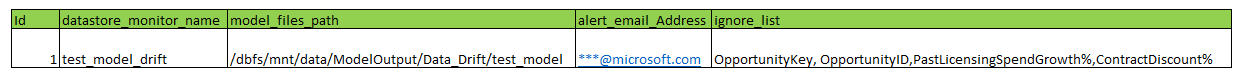

### Step 5 Run the data drift monitor for multiple model in sequence

* Using below python code along with information stored in metadata file and data drift function, we can create/update/daily run the data drift for multiple model in sequence


In [ ]:
metadata_df = pd.read_csv('<MetaData file input>')

for i in range(len(metadata_df)):
    print ('################## Input for the current run ###############################')
    print ('####### model_files_path       ',metadata_df['model_files_path'][i])
    print ('####### model_datastore_name   ',metadata_df['datastore_monitor_name'][i] )
    print ('####### model_datamonitor_name ',metadata_df['datastore_monitor_name'][i] )
    print ('####### exclude_list           ',metadata_df['ignore_list'][i] )
    print ('####### alert_email_Address    ',metadata_df['alert_email_Address'][i] )
    print ('######################################################################')
  
    model_files_path, model_datastore_name, model_datamonitor_name = metadata_df['model_files_path'][i],metadata_df['datastore_monitor_name'][i],metadata_df['datastore_monitor_name'][i]
    exclude_list = list(str(metadata_df['ignore_list'][i]).split(","))
    print('final parameter  ', model_files_path, model_datastore_name, model_datamonitor_name,exclude_list)
    try:
  #data_drift_function(model_files_path, model_datastore_name, model_datamonitor_name,exclude_list,code_type,['****@microsoft.com'])
        backfill = data_drift_function(model_files_path, model_datastore_name, model_datamonitor_name,['****@microsoft.com'],exclude_list)

    except:
        print('Error found for  ', model_files_path, model_datastore_name, model_datamonitor_name,['****@microsoft.com'],exclude_list)